In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')


2024-03-11 18:46:50.960524: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-11 18:46:51.004495: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 18:46:51.004531: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 18:46:51.004556: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 18:46:51.013191: I tensorflow/core/platform/cpu_feature_g

In [2]:
file_path = "myData2.parquet"
df = pd.read_parquet(file_path)

In [3]:
selected_features = ['timestamp_seconds', 
                     'node_memory_Percpu_bytes', 
                     'node_context_switches_total', 
                     'surfsara_power_usage', 
                     'node_netstat_Tcp_InSegs', 
                     'node_netstat_Tcp_OutSegs', 
                     'node_network_transmit_packets_total-sum', 
                     'node_filesystem_size_bytes-sum', 
                     'node_filesystem_files-sum', 
                     'node_memory_MemFree_bytes', 
                     'node_netstat_Tcp_InErrs']
# FixMe

In [4]:
# selected_features = ['timestamp_seconds', 
#                      'node_memory_Percpu_bytes', 
#                      'node_context_switches_total', 
#                      'surfsara_power_usage', 
#                      'node_netstat_Tcp_InSegs', 
#                      'node_netstat_Tcp_OutSegs', 
#                      'node_network_transmit_packets_total-sum', 
#                      'node_filesystem_size_bytes-sum', 
#                      'node_filesystem_files-sum', 
#                      'node_memory_MemFree_bytes', 
#                      'node_netstat_Tcp_InErrs']


In [5]:
# Define time intervals
time_intervals = {'minute': '1T', 'hour': '1H', 'day': '1D'}

# Set sequence length
sequence_length = 30

# Number of time steps to predict into the future
prediction_steps = 7

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [6]:
# Function to prepare data for LSTM
def prepare_lstm_data(data, time_interval):
    data.set_index('timestamp', inplace=True)
    data_resampled = data.resample(time_interval).sum()
    
    target_mean = data_resampled['target'].mean()
    target_std = data_resampled['target'].std()
    data_resampled['target'] = (data_resampled['target'] - target_mean) / target_std
    
    target_min = data_resampled['target'].min()
    target_max = data_resampled['target'].max()
    print("Minimum value of target variable:", target_min)
    print("Maximum value of target variable:", target_max)
    
    return data_resampled


In [7]:
# Function to create sequences for LSTM
def create_lstm_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length].values
        target = data.iloc[i+sequence_length]['target']
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)


In [8]:
# Function to make predictions on new data
def predict_future_failures(model, input_data, sequence_length, prediction_steps):
    predictions = []

    for _ in range(prediction_steps):
        # Make a prediction for the next time step
        prediction = model.predict(input_data.reshape(1, sequence_length, input_data.shape[1]))
        predictions.append(prediction[0, 0])

        # Shift the input data by one time step and append the new prediction
        input_data = np.roll(input_data, shift=-1, axis=0)
        input_data[-1, -1] = prediction[0, 0]

    return predictions


# 30 days -> 7 days

In [9]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [74]:
#DeleteMe
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])
#DeleteMe

# Prepare data for LSTM with daily intervals
lstm_data_day = prepare_lstm_data(df_selected, time_intervals['day'])

# Create sequences and targets
sequences_day, targets_day = create_lstm_sequences(lstm_data_day, sequence_length)

# Define the index to split the data
split_index_day = int(len(sequences_day) * 0.7)  # Use 70% of the data for training

# Split the data into training and testing sets
X_train_day, X_test_day = sequences_day[:split_index_day], sequences_day[split_index_day:]
y_train_day, y_test_day = targets_day[:split_index_day], targets_day[split_index_day:]

# Build the LSTM model
lstm_model_day = Sequential()
lstm_model_day.add(LSTM(8, input_shape=(X_train_day.shape[1], X_train_day.shape[2])))
lstm_model_day.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.0005)
lstm_model_day.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

# Train the model
history_day = lstm_model_day.fit(X_train_day, y_train_day, epochs=20, batch_size=32, validation_split=0.1)

#DeleteMe
# Evaluate the model using Mean Squared Error
mse_day = lstm_model_day.evaluate(X_test_day, y_test_day, verbose=0)[1]
print(f'Model Mean Squared Error: {mse_day:.4f}\n')

# Evaluate model on test data
y_pred_day = lstm_model_day.predict(X_test_day)

# Calculate Root Mean Squared Error
rmse = mean_squared_error(y_test_day, y_pred_day, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test_day, y_pred_day)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared
r2 = r2_score(y_test_day, y_pred_day)
print("R-squared (R2):", r2)

# Additional: Compare with training and validation loss from history
train_loss = history_day.history['loss']
val_loss = history_day.history['val_loss']


Minimum value of target variable: -0.7362924419461765
Maximum value of target variable: 5.322951443655186
Epoch 1/20
2/2 [==============================] - 2s 473ms/step - loss: 1.0019 - mean_squared_error: 1.0019 - val_loss: 1.2284 - val_mean_squared_error: 1.2284
Epoch 2/20
2/2 [==============================] - 0s 66ms/step - loss: 1.0014 - mean_squared_error: 1.0014 - val_loss: 1.2278 - val_mean_squared_error: 1.2278
Epoch 3/20
2/2 [==============================] - 0s 67ms/step - loss: 1.0008 - mean_squared_error: 1.0008 - val_loss: 1.2272 - val_mean_squared_error: 1.2272
Epoch 4/20
2/2 [==============================] - 0s 67ms/step - loss: 0.9993 - mean_squared_error: 0.9993 - val_loss: 1.2266 - val_mean_squared_error: 1.2266
Epoch 5/20
2/2 [==============================] - 0s 65ms/step - loss: 0.9962 - mean_squared_error: 0.9962 - val_loss: 1.2260 - val_mean_squared_error: 1.2260
Epoch 6/20
2/2 [==============================] - 0s 64ms/step - loss: 0.9957 - mean_squared_error

## Performance_Day

In [11]:
# Evaluate the model using Mean Squared Error
mse_day = lstm_model_day.evaluate(X_test_day, y_test_day, verbose=0)[1]
print(f'Mean Squared Error: {mse_day:.4f}\n')


Mean Squared Error: 2.0761



In [12]:
# Evaluate model on test data
y_pred_day = lstm_model_day.predict(X_test_day)

# Calculate Root Mean Squared Error
rmse_day = mean_squared_error(y_test_day, y_pred_day, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_day:.4f}\n')

# Calculate Mean Absolute Error
mae_day = mean_absolute_error(y_test_day, y_pred_day)
print(f'Mean Abosolute Error: {mae_day:.4f}\n')

# Calculate R-squared
r2_day = r2_score(y_test_day, y_pred_day)
print(f'R-squared (R2): {r2_day:.4f}\n')


1/1 [==============================] - 0s 23ms/step
Root Mean Squared Error (RMSE): 1.4409

Mean Abosolute Error: 1.0801

R-squared (R2): -0.0021



### Training and Validation Loss Plot

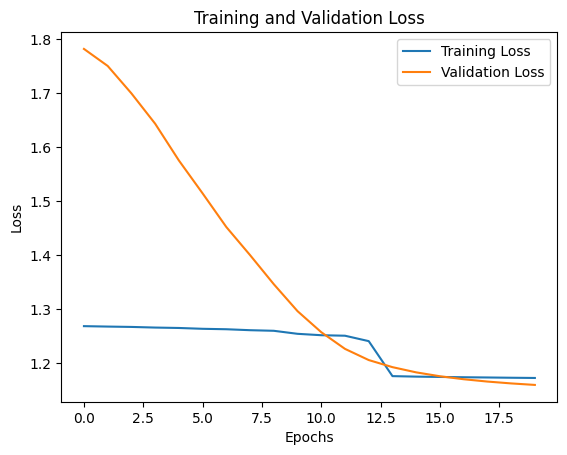

In [13]:
# Plot training and validation loss
plt.plot(history_day.history['loss'], label='Training Loss')
plt.plot(history_day.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

In [ ]:
target_min_day = -0.7362924419461765
target_max_day = 5.322951443655186

1/1 [==============================] - 0s 20ms/step
Predicted failures for the next 7 days:
[0.46868104, 0.46868104, 0.46868104, 0.46868104, 0.46868104, 0.46868104, 0.46868104]

Mean Squared Error for Predictions: 0.9145

Mean Absolute Error for Predictions: 0.8400


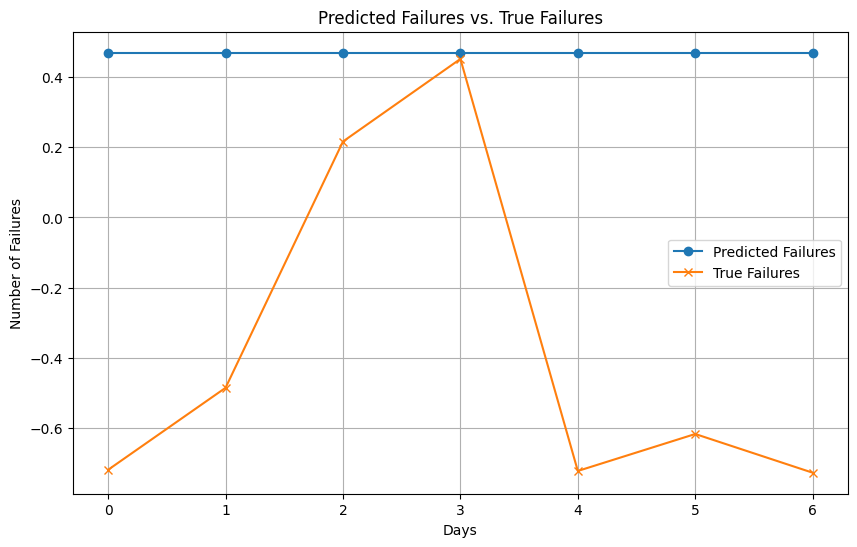

In [70]:
index_day = 0  # Can be any valid starting point

input_data_day = X_test_day[index_day]

# Make predictions
predicted_failures_day = predict_future_failures(lstm_model_day, input_data_day, sequence_length, prediction_steps)

# # Denormalize the predicted failures 
# predicted_failures_denormalized_day = np.array(predicted_failures_day) * (target_max_day - target_min_day) + target_min_day

# Get the true failures for the specified number of days
true_failures_day = y_test_day[index_day:index_day + prediction_steps]

# Print the predicted failures
print("Predicted failures for the next 7 days:")
print(predicted_failures_day)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_day - true_failures_day)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_day - true_failures_day))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_day, label='Predicted Failures', marker='o')
plt.plot(true_failures_day, label='True Failures', marker='x')
plt.xlabel('Days')
plt.ylabel('Number of Failures')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.grid(True)
plt.show()


# 30 hours -> 7 hours

In [15]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [16]:
# Prepare data for LSTM with hourly intervals
lstm_data_hour = prepare_lstm_data(df_selected, time_intervals['hour'])

# Create sequences and targets
sequences_hour, targets_hour = create_lstm_sequences(lstm_data_hour, sequence_length)

# Define the index to split the data
split_index_hour = int(len(sequences_hour) * 0.7)  # Use 70% of the data for training

# Split the data into training and testing sets
X_train_hour, X_test_hour = sequences_hour[:split_index_hour], sequences_hour[split_index_hour:]
y_train_hour, y_test_hour = targets_hour[:split_index_hour], targets_hour[split_index_hour:]

# Build the LSTM model
lstm_model_hour = Sequential()
lstm_model_hour.add(LSTM(20, input_shape=(X_train_hour.shape[1], X_train_hour.shape[2])))
lstm_model_hour.add(Dense(1, activation='sigmoid')) # FixMe
lstm_model_hour.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
history_hour = lstm_model_hour.fit(X_train_hour, y_train_hour, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


Minimum value of target variable: -0.44004356707964004
Maximum value of target variable: 22.33986610637043
Epoch 1/20
54/54 [==============================] - 3s 30ms/step - loss: 0.4140 - mean_squared_error: 0.4140 - val_loss: 0.4088 - val_mean_squared_error: 0.4088
Epoch 2/20
54/54 [==============================] - 1s 22ms/step - loss: 0.2873 - mean_squared_error: 0.2873 - val_loss: 0.3743 - val_mean_squared_error: 0.3743
Epoch 3/20
54/54 [==============================] - 1s 22ms/step - loss: 0.2474 - mean_squared_error: 0.2474 - val_loss: 0.3504 - val_mean_squared_error: 0.3504
Epoch 4/20
54/54 [==============================] - 1s 21ms/step - loss: 0.2366 - mean_squared_error: 0.2366 - val_loss: 0.2882 - val_mean_squared_error: 0.2882
Epoch 5/20
54/54 [==============================] - 1s 21ms/step - loss: 0.2194 - mean_squared_error: 0.2194 - val_loss: 0.2839 - val_mean_squared_error: 0.2839
Epoch 6/20
54/54 [==============================] - 1s 20ms/step - loss: 0.2122 - mean_s

## Performance_Hour

In [17]:
# Evaluate the model using Mean Squared Error
mse_hour = lstm_model_hour.evaluate(X_test_hour, y_test_hour, verbose=0)[1]
print(f'Model Mean Squared Error: {mse_hour:.4f}\n')


Model Mean Squared Error: 2.7412



In [18]:
# Evaluate model on test data
y_pred_hour = lstm_model_hour.predict(X_test_hour)

# Calculate Root Mean Squared Error
rmse_hour = mean_squared_error(y_test_hour, y_pred_hour, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_hour:.4f}\n')

# Calculate Mean Absolute Error
mae_hour = mean_absolute_error(y_test_hour, y_pred_hour)
print(f'Mean Abosolute Error: {mae_hour:.4f}\n')

# Calculate R-squared
r2_hour = r2_score(y_test_hour, y_pred_hour)
print(f'R-squared (R2): {r2_hour:.4f}\n')


26/26 [==============================] - 1s 7ms/step
Root Mean Squared Error (RMSE): 1.6557

Mean Abosolute Error: 0.6876

R-squared (R2): -0.0028



### Training and Validation Loss Plot

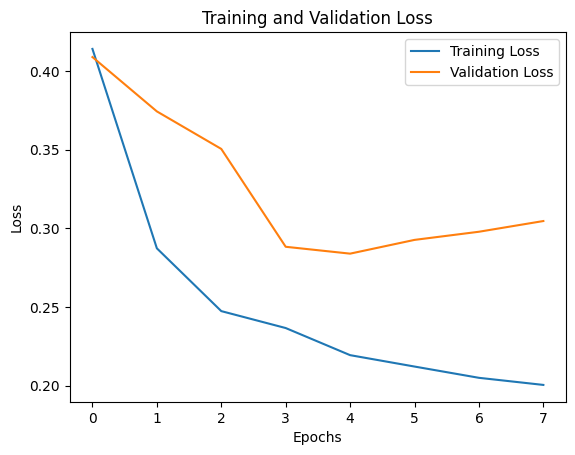

In [19]:
# Plot training and validation loss
plt.plot(history_hour.history['loss'], label='Training Loss')
plt.plot(history_hour.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

In [62]:
target_min_hour =  0.44004356707964004
target_max_hour = 22.33986610637043

1/1 [==============================] - 0s 20ms/step
Predicted failures for the next 7 hours:
[0.042711522, 0.05224526, 0.055317327, 0.05702324, 0.057085957, 0.057038147, 0.056967508]

Mean Squared Error for Predictions: 0.0474

Mean Absolute Error for Predictions: 0.2178


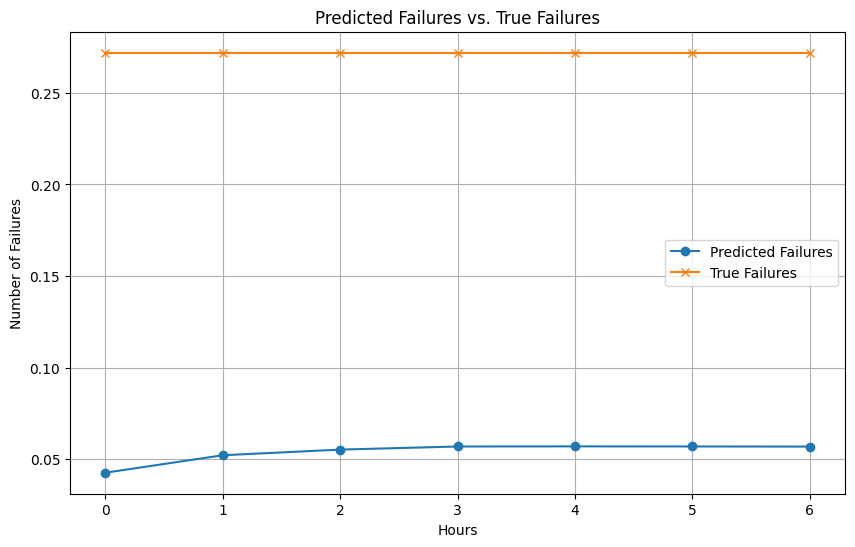

In [67]:
index_hour = 500  # Can be any valid starting point

input_data_hour = X_test_hour[index_hour]

# Make predictions
predicted_failures_hour = predict_future_failures(lstm_model_hour, input_data_hour, sequence_length, prediction_steps)

# # Denormalize the predicted failures 
# predicted_failures_denormalized_hour = np.array(predicted_failures_hour) * (target_max_hour - target_min_hour) + target_min_hour

# Get the true failures for the specified number of hours
true_failures_hour = y_test_hour[index_hour:index_hour + prediction_steps] 

# Print the predicted failures
print("Predicted failures for the next 7 hours:")
print(predicted_failures_hour)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_hour - true_failures_hour)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_hour - true_failures_hour))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_hour, label='Predicted Failures', marker='o')
plt.plot(true_failures_hour, label='True Failures', marker='x')
plt.xlabel('Hours')
plt.ylabel('Number of Failures')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.grid(True)
plt.show()


# 30 minutes -> 7 minutes

In [21]:
# Extract relevant columns
df_selected = df[['timestamp', 'state'] + selected_features].copy()

# Encode the target variable 'state' to binary (0 for "COMPLETED", 1 otherwise)
df_selected['target'] = (df_selected['state'] != 'COMPLETED').astype(int)

# Drop the original 'state' column
df_selected.drop('state', axis=1, inplace=True)

# Normalize selected features
scaler = MinMaxScaler()
df_selected[selected_features] = scaler.fit_transform(df_selected[selected_features])


In [22]:
# Prepare data for LSTM with minute intervals
lstm_data_min = prepare_lstm_data(df_selected, time_intervals['minute'])

# Create sequences and targets
sequences_min, targets_min = create_lstm_sequences(lstm_data_min, sequence_length)

# Define the index to split the data
split_index_min = int(len(sequences_min) * 0.7)  # Use 70% of the data for training

# Split the data into training and testing sets
X_train_min, X_test_min = sequences_min[:split_index_min], sequences_min[split_index_min:]
y_train_min, y_test_min = targets_min[:split_index_min], targets_min[split_index_min:]

# Build the LSTM model
lstm_model_min = Sequential()

# 50 -> 10
lstm_model_min.add(LSTM(2, input_shape=(X_train_min.shape[1], X_train_min.shape[2])))
lstm_model_min.add(Dense(1, activation='sigmoid')) #FixMe
lstm_model_min.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Train the model
history_min = lstm_model_min.fit(X_train_min, y_train_min, epochs=5, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


Minimum value of target variable: -0.43499466427008204
Maximum value of target variable: 22.077561101301857
Epoch 1/5
3258/3258 [==============================] - 62s 19ms/step - loss: 0.2337 - mean_squared_error: 0.2337 - val_loss: 0.2280 - val_mean_squared_error: 0.2280
Epoch 2/5
3258/3258 [==============================] - 60s 18ms/step - loss: 0.1586 - mean_squared_error: 0.1586 - val_loss: 0.1949 - val_mean_squared_error: 0.1949
Epoch 3/5
3258/3258 [==============================] - 59s 18ms/step - loss: 0.1381 - mean_squared_error: 0.1381 - val_loss: 0.1892 - val_mean_squared_error: 0.1892
Epoch 4/5
3258/3258 [==============================] - 60s 18ms/step - loss: 0.1344 - mean_squared_error: 0.1344 - val_loss: 0.1883 - val_mean_squared_error: 0.1883
Epoch 5/5
3258/3258 [==============================] - 60s 18ms/step - loss: 0.1337 - mean_squared_error: 0.1337 - val_loss: 0.1882 - val_mean_squared_error: 0.1882


## Performance_Minute

In [23]:
# Evaluate the model using Mean Squared Error
mse_min = lstm_model_min.evaluate(X_test_min, y_test_min, verbose=0)[1]
print(f'Mean Squared Error: {mse_min:.4f}\n')


Mean Squared Error: 2.1595



In [24]:
# Evaluate model on test data
y_pred_min = lstm_model_min .predict(X_test_min )

# Calculate Root Mean Squared Error
rmse_min = mean_squared_error(y_test_min, y_pred_min, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse_min:.4f}\n')

# Calculate Mean Absolute Error
mae_min = mean_absolute_error(y_test_min, y_pred_min)
print(f'Mean Abosolute Error: {mae_min:.4f}\n')

# Calculate R-squared
r2_min = r2_score(y_test_min, y_pred_min)
print(f'R-squared (R2): {r2_min:.4f}\n')


1552/1552 [==============================] - 9s 6ms/step
Root Mean Squared Error (RMSE): 1.4695

Mean Abosolute Error: 0.4771

R-squared (R2): 0.2011



### Training and Validation Loss Plot

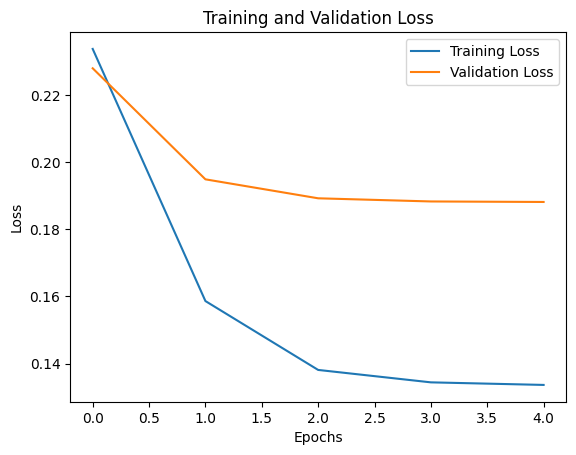

In [25]:
# Plot training and validation loss
plt.plot(history_min.history['loss'], label='Training Loss')
plt.plot(history_min.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


### Predicted Failures vs. True Failures Plot

In [30]:
target_min_min =  -0.43499466427008204
target_max_min = 22.077561101301857

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step
Predicted failures for the next 7 minutes:
[0.00016232277, 0.00035059312, 0.00069211115, 0.0011786029, 0.001752023, 0.0023590894, 0.0029624652]

Mean Squared Error for Predictions: 0.1904

Mean Absolute Error for Predictions: 0.4363


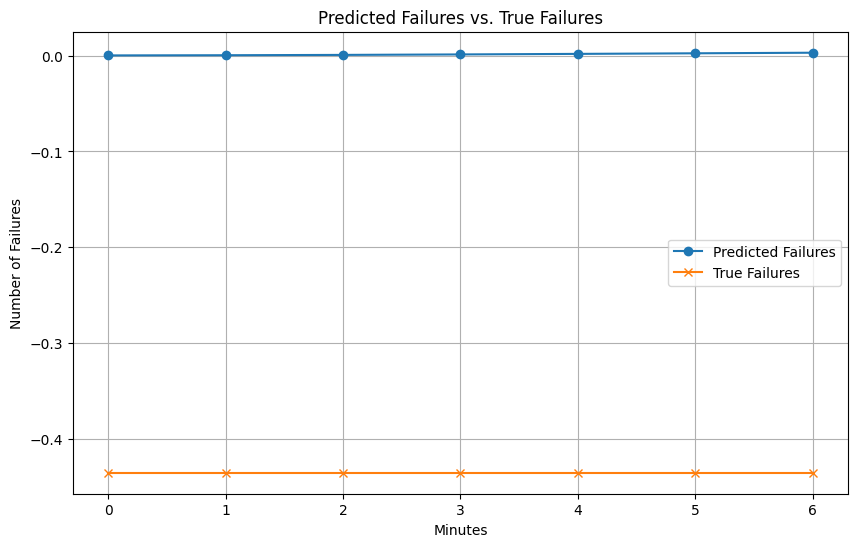

In [69]:
index_min = 0  # Can be any valid starting point

input_data_min = X_test_min[index_min]

# Make predictions
predicted_failures_min = predict_future_failures(lstm_model_min, input_data_min, sequence_length, prediction_steps)

# # Denormalize the predicted failures 
# predicted_failures_denormalized_min = np.array(predicted_failures_min) * (target_max_min- target_min_min) + target_min_min

# Get the true failures for the specified number of minutes
true_failures_min = y_test_min[index_min:index_min + prediction_steps]

# Print the predicted failures
print("Predicted failures for the next 7 minutes:")
print(predicted_failures_min)

# Evaluate the predictions using Mean Squared Error
mse_predictions = np.mean((predicted_failures_min - true_failures_min)**2)
print(f'\nMean Squared Error for Predictions: {mse_predictions:.4f}\n')

# Evaluate the predictions using Mean Absolute Error
mae_predictions = np.mean(np.abs(predicted_failures_min - true_failures_min))
print(f'Mean Absolute Error for Predictions: {mae_predictions:.4f}')

# Plot predicted failures vs. true failures
plt.figure(figsize=(10, 6))
plt.plot(predicted_failures_min, label='Predicted Failures', marker='o')
plt.plot(true_failures_min, label='True Failures', marker='x')
plt.xlabel('Minutes')
plt.ylabel('Number of Failures')
plt.title('Predicted Failures vs. True Failures')
plt.legend()
plt.grid(True)
plt.show()
